# GAN 빈칸 문제

['code here'] 부분을 주석 처리된 힌트를 보고 채워주세요
#### 코랩 - GPU 설정을 반드시 확인해주세요 

# 캐글과 코랩 연동하기

안되면 
https://kubig-2021-2.tistory.com/35 
https://jaaamj.tistory.com/141
이 링크를 참고해주세요

In [16]:
# 캐글 API 올리기 

!pip install kaggle
from google.colab import files
files.upload()

# 파일 선택이 나오면 캐글 API에서 다운받은 kaggle.json을 업로드해주세요

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeseungyu","key":"c4215af45d39d4935fd812fdce88e4c0"}'}

In [17]:
ls -1ha kaggle.json # kaggle.json이 나오면 정상적으로 실행된 것입니다

kaggle.json


In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
!kaggle datasets download -d karnikakapoor/art-portraits #데이터셋 다운로드

100% 1.30G/1.30G [00:12<00:00, 144MB/s]
100% 1.30G/1.30G [00:12<00:00, 115MB/s]


In [ ]:
!unzip art-portraits.zip # 불러온 파일 압축 해제

In [21]:
!ls #파일 확인

art-portraits.zip  kaggle.json	Portraits  sample_data


In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("../input/art-portraits/Portraits/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">ART BY GAN</p>

<img src="https://github.com/KarnikaKapoor/Files/blob/main/Gan1.gif?raw=true">

<p style="font-family:newtimeroman;font-size:120%;color:#95856a;">In this Notebook, I will build a Generative Adversarial Network  (GAN) to illustrate the workings of a Generative Adversarial Network and to generate images. Generative modelling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data. As GANs work by identifying the patterns in the data, I will be using oil painted portraits. However, glancing over the dataset gives me an idea that it is going to be a long shot. The orientation and poses in the dataset vary vastly. Keeping that in mind I am still willing to give it a try. Only because portraits are my jam. I basically love oil painted portraits.</p> 

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
 <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. DATA LOADING & PREPREPROCESSING](#2)
    
* [3. BUILDING GAN](#3)
    * [3.1 The Generator](#3.1)
    * [3.2 The Discriminator](#3.2)
    
    
* [4. GAN COMPILATION](#4)  
    
* [5. TRAINING THE MODEL](#5) 
      
* [6. EVALUATING THE MODEL](#6)
    
* [7. CONCLUSION](#7)
    
* [8. END](#8)


<a id="1"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">IMPORTING LIBRARIES</p>
    
<p style="font-family:newtimeroman;color:#95856a;font-size:150%">The following Libraries will be used in the project</p>
    

In [23]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

##### <a id="2"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">DATA LOADING & PREPREPROCESSING</p>

For this project, I am using .jpg files of images of portraits. The dataset includes various artists. I am loading data as TensorFlow.Dataset,, with a batch size of 64. I have reduced the image size to (64,64), presuming, it will be computationally less taxing on the GPU.

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Loading the data</p>

In [24]:
#Importing data
data_path = "/content/Portraits" #코랩 파일 탐색기에서 Portraits가 있는 폴더의 경로 복사를 해준 뒤 붙여넣기 해주세요
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


Now that I have the dataset loaded, let us have a look at a few images.

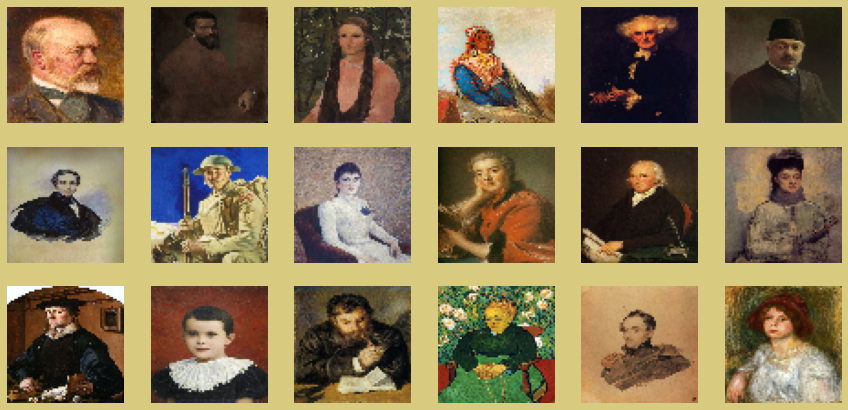

In [25]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

Most of the images are portraits. A portrait is a painting representation of a person, The face is predominantly depicted portraits along with expressions and postures. To represent the personality of the subject. Since our model is relative a smaller GAN we have reduced the size of the image. 

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Preprocessing the data</p>

**Normalization:** For the data normalization, I will convert the data in the range between 0 to 1. This helps in fast convergence and makes it easy for the computer to do calculations faster. 
Each of the three RGB channels in the image can take pixel values ranging from 0 to 256. Dividing it by 255 converts it to a range between 0 to 1. By doing this we 

In [26]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

Now the data is up as a tensorflow Dataset object and is Prepocessed. Next up is building the GAN. 

<a id="3"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">BUILDING GAN</p>

GANs employs deep learning methods. It is a dexterous way of posing the problem as a supervised learning problem. It is composed of two models namely Generator and a Discriminator.

Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look like the dataset while a discriminator ("the art critic") learns to tell real images apart from fakes.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

<img src="https://github.com/KarnikaKapoor/Files/blob/main/Gan2.png?raw=true">    

**In this section I will be:**
* Building a Generator
* Building a Discriminator

<a id="3.1"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">The Generator</p>

The Generator is a neural network that generates the images. It takes in a random noise as seed and outputs sample data. As the GAN's training progresses the Generator output becomes more and more like the training set, as the Generator tries to improve the output so that the discrimination passes the output as a real image. 

**Following steps are involved in the models building**

* Initialising the Model
* Defining by adding layers

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Building a Generator</p>

### 문제는 이 아래부터 있습니다

In [33]:
from keras.engine import input_layer
latent_dim = 100
g_resolution=2

#Building a Generator
generator = tf.keras.models.Sequential() # generator 생성

generator.add(Dense(4*4*256, activation='relu', input_dim=latent_dim))  
#크기 4*4*256, 활성화 함수 relu, 입력 차원은 latent_dim
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)        

Now that the Generator is framed, let us see what random output our untrained Generator produces to get an idea of the process. 

(-0.5, 63.5, 63.5, -0.5)

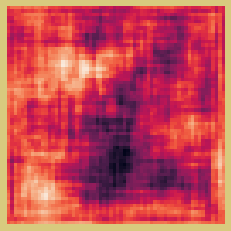

In [34]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

Clearly, the output is a random seed containing noise as the Generator is not trained yet. 

<a id="3.2"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">The Discriminator</p>

In GANs the Generator works along with the Discriminator. 

The Discriminator network decided whether the data is fake aka created by the Generator or real i.e. from the original input data. To do so it applies a binary classification method using a sigmoid function to get an output in the range of 0 to 1.

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Building a Discriminator</p>

In [36]:
#Building a Discriminator
discriminator = tf.keras.models.Sequential()  #판별자 함수 생성
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding='same')) 
#CNN 층 생성, 크기 32, kernel_size는 3, stride는 2, input_shape는 64, 64, 3, padding은 same
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

Now with this discriminator(untrained), let us see what verdict it has for the preiously generated image with random noise. 

In [37]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.49956372]], shape=(1, 1), dtype=float32)


The output of the discriminator i.e. The Verdict, Says that there is almost a fifty-fifty chance of the image being real. This is so because the Discriminator is not yet trained. So basically, An untrained Generarator generated some pixel-noise and the untrained Discriminator classified it as "can't tell". So far we are on a right track. 

Let us proceed and build the GAN architecture to train.

<a id="4"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">GAN COMPILATION</p>

GAN training has two sections:

**Section 1**: The Discriminator is trained while the Generator is idle. 
The discriminator is trained real images and random noise (from an untrained generator). This trains it to tell between fake and real. This accommodates the discriminator to predict as fakes.

**Section 2**: The Generator is trained while the Discriminator is idle.  In this section, the generator is trained.  After training the Discriminator, this step uses the predictions from the discriminator. Grants the generator to adjust the weights to try to deceive the discriminator. 

The above method is repeated for a few epochs.  

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">The next section defines the GAN training</p>

In [44]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator #판별자 모델 입력
        self.generator = generator # 생성자 모델 입력
        self.latent_dim = latent_dim # latent_dim 입력

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

<a id="5"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">TRAINING THE MODEL</p>

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Train the model</p> Calling the above created GAN function trains the generator and discriminator simultaneously. 

To implement the GAN we must define:
* Number of epochs
* The optimizers for Generator and Discriminator
* The cross-entropy loss

After defing optimizers and numbers of epochs, We will define, compile and fit the model. 

In [45]:
#Defining the number of epochs  
# 원래 에포크는 200인데 너무 오래 걸려서 30으로 줄였습니다. 하고 싶으시면 200으로 늘려서 시도해보세요
# 학습 시간이 꽤 걸리므로 실행해놓고 다른거 하세요....
epochs = 30
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/30
65/65 [==============================] - 51s 519ms/step - d_loss: 0.6609 - g_loss: 0.7500
Epoch 2/30
65/65 [==============================] - 38s 509ms/step - d_loss: 0.6819 - g_loss: 0.7345
Epoch 3/30
65/65 [==============================] - 37s 492ms/step - d_loss: 0.6752 - g_loss: 0.7858
Epoch 4/30
65/65 [==============================] - 35s 484ms/step - d_loss: 0.6747 - g_loss: 0.8207
Epoch 5/30
65/65 [==============================] - 37s 507ms/step - d_loss: 0.6648 - g_loss: 0.8303
Epoch 6/30
65/65 [==============================] - 37s 510ms/step - d_loss: 0.6631 - g_loss: 0.8047
Epoch 7/30
65/65 [==============================] - 36s 499ms/step - d_loss: 0.6417 - g_loss: 0.8685
Epoch 8/30
65/65 [==============================] - 36s 490ms/step - d_loss: 0.5954 - g_loss: 0.9425
Epoch 9/30
65/65 [==============================] - 36s 489ms/step - d_loss: 0.5654 - g_loss: 1.1064
Epoch 10/30
65/65 [==============================] - 36s 497ms/step - d_loss: 0.5401 - g_lo

<a id="6"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">EVALUATING THE MODEL</p>

Now that I have my model trained, let us see how it performs.
Having a look at the performance of the model via Learning Curves

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">Ploting the Learning Curves</p>

Text(0.5, 1.0, 'Learning Curve')

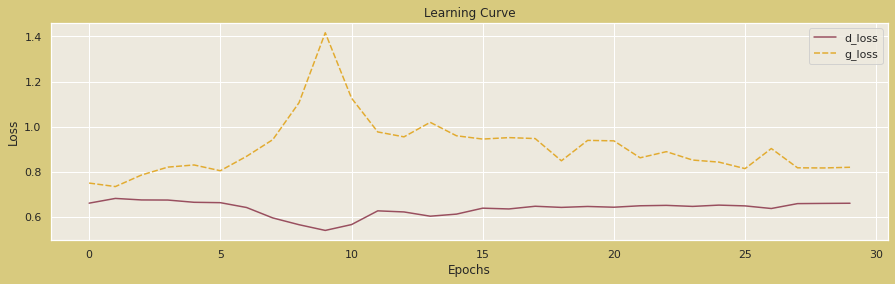

In [46]:
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

This looks alright-ish! 

Let us get some portraits done by the GAN and appreciate the art created by this AI. 
To get the art output I will create a function that saves the output portraits generated. We will be plotting the generated Portraits

<p style="font-family:newtimeroman;color:#95856a;font-size:150%">AI makes Artwork</p>

In [47]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i)) 
    return 

#Generating images
Images = Potrait_Generator()

Found 4135 files belonging to 1 classes.


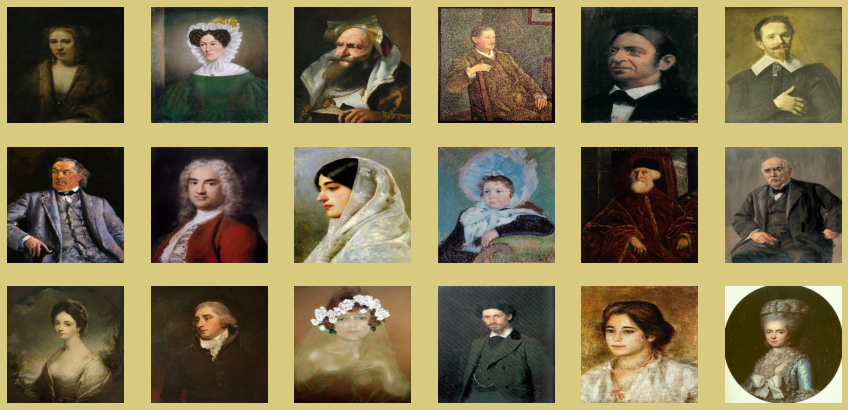

In [48]:
#Loading generated images
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)

<a id="7"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">CONCLUSION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#95856a">In the evaluation of the model: We can see that the GAN picked up the patterns in the portraits. It worked quite well. For further improvement,  as GANs are notorious for being data-hungry, I would consider increasing the dataset. There are many inconsistencies in the data which is rather complicated for the GAN to learn. Cleaning the data with some consistencies in the portrait styles would certainly help. Training it longer i.e. for more epochs would also help. Lastly, one can always strive to make a  more robust architecture for the Neural Networks. </p> 

**Read More On My Blog:** [here](https://karnikakapoor.blogspot.com/2021/12/ai-art.html)
     

**Resources:**

[TensorFlow DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)

[Keras DCGAN](https://keras.io/examples/generative/dcgan_overriding_train_step/) 

[Training a GAN](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)


<p style="background-color:#EDE9DE;font-family:newtimeroman;color:#95856a;font-size:130%;text-align:center;border-radius:20px 20px;"> If you liked this Notebook, please do upvote.<br> If you have any questions, feel free to comment!<br> ✨Best Wishes✨</p>

<a id="8"></a>
# <p style="background-color:#95856a;font-family:newtimeroman;color:#D8CA7E;font-size:120%;text-align:center;border-radius:40px 40px;">END</p>